#Exploring precision and recall

In [1]:
import pandas as pd
import numpy as np
products = pd.read_csv('/Users/April/Downloads/amazon_baby.csv')
products.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


##Perform text cleaning

We start by removing punctuation, so that words "cake." and "cake!" are counted as the same word.
Write a function remove_punctuation that strips punctuation from a line of text Apply this function to every element in the review column of products, and save the result to a new column review_clean. Refer to your tool's manual for string processing capabilities. Python lets us express the operation in a succinct way, as follows:

In [2]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

In [3]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

In [4]:
products['review_clean'] = products['review'].apply(remove_punctuation)

##Extract Sentiments

We will ignore all reviews with rating = 3, since they tend to have a neutral sentiment.

In [5]:
products = products[products['rating'] != 3]


Now, we will assign reviews with a rating of 4 or higher to be positive reviews, while the ones with rating of 2 or lower are negative. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label. A good way is to create an anonymous function that converts a rating into a class label and then apply that function to every element in the rating column.

In [6]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [7]:
products.head()

,name,review,rating,review_clean,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,When the Binky Fairy came to our house we didn...,1


In [8]:
train_indice = open('/Users/April/Documents/train_indice.txt','r')
for line in train_indice:
    train_list = [int(x.strip()) for x in line.split(',')]
    
train_data = products.iloc[train_list]
test_indice = open('/Users/April/Documents/test_indice.txt','r')
for line in test_indice:
    test_list = [int(x.strip()) for x in line.split(',')]
test_data = products.iloc[test_list]

##Build the word count vector for each review

We will now compute the word count for each word that appears in the reviews. A vector consisting of word counts is often referred to as bag-of-word features. Since most words occur in only a few reviews, word count vectors are sparse. For this reason, scikit-learn and many other tools use sparse matrices to store a collection of word count vectors. Refer to appropriate manuals to produce sparse word count vectors. General steps for extracting word count vectors are as follows:
Learn a vocabulary (set of all words) from the training data. Only the words that show up in the training data will be considered for feature extraction. Compute the occurrences of the words in each review and collect them into a row vector. Build a sparse matrix where each row is the word count vector for the corresponding review. Call this matrix train_matrix. Using the same mapping between words and columns, convert the test data into a sparse matrix test_matrix.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

##Train a sentiment classifier with logistic regression

We will now use logistic regression to create a sentiment classifier on the training data.
Learn a logistic regression classifier using the training data. If you are using scikit-learn, you should create an instance of the LogisticRegression class and then call the method fit() to train the classifier. This model should use the sparse word count matrix (train_matrix) as features and the column sentiment of train_data as the target. Use the default values for other parameters. Call this model sentiment_model.

In [10]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LogisticRegression

In [11]:
model = LogisticRegression()

In [12]:
model.fit(train_matrix, train_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

##Model Evaluation

###Accuracy

In [14]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_data['sentiment'], y_pred=model.predict(test_matrix))
print "Test Accuracy: %s" % accuracy

Test Accuracy: 0.932295416367


###Baseline: Majority class prediction

In [16]:
baseline = float(len(test_data[test_data['sentiment'] == 1]))/len(test_data)
print "Baseline accuracy (majority class classifier): %s" % baseline

Baseline accuracy (majority class classifier): 0.842782577394


###Confusion Matrix

The accuracy, while convenient, does not tell the whole story. For a fuller picture, we turn to the confusion matrix. In the case of binary classification, the confusion matrix is a 2-by-2 matrix laying out correct and incorrect predictions made in each label as follows:

Using your tool, print out the confusion matrix for a classifier. For instance, scikit-learn provides the method confusion_matrix for this purpose:

In [19]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'],
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3788
     -1       |        1        |  1453
      1       |       -1        |   804
      1       |        1        | 27291


Quiz Question: How many predicted values in the test set are false positives?

###Computing the cost of mistakes

In [20]:
cost = 100*1453+1*804

In [21]:
cost

146104

###Precision and Recall

You may not have exact dollar amounts for each kind of mistake. Instead, you may simply prefer to reduce the percentage of false positives to be less than, say, 3.5% of all positive predictions. This is where precision comes in:
$$
[\text{precision}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all data points with positive predictions]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false positives}]}
$$
So to keep the percentage of false positives below 3.5% of positive predictions, we must raise the precision to 96.5% or higher.
First, let us compute the precision of the logistic regression classifier on the test_data.

In [22]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'], 
                            y_pred=model.predict(test_matrix))
print "Precision on test data: %s" % precision

Precision on test data: 0.949450320067


Quiz Question: Out of all reviews in the test set that are predicted to be positive, what fraction of them are false positives? (Round to the second decimal place e.g. 0.25)

In [23]:
1-precision

0.050549679933203473

A complementary metric is recall, which measures the ratio between the number of true positives and that of (ground-truth) positive reviews:
$$
[\text{recall}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all positive data points]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false negatives}]}
$$
Let us compute the recall on the test_data.

In [24]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'],
                      y_pred=model.predict(test_matrix))
print "Recall on test data: %s" % recall

Recall on test data: 0.971382808329


Quiz Question: What fraction of the positive reviews in the test_set were correctly predicted as positive by the classifier?

Quiz Question: What is the recall value for a classifier that predicts +1 for all data points in the test_data?

###precision-recall tradeoff

In this part, we will explore the trade-off between precision and recall discussed in the lecture. We first examine what happens when we use a different threshold value for making class predictions. We then explore a range of threshold values and plot the associated precision-recall curve.

###Varying the threshold

False positives are costly in our example, so we may want to be more conservative about making positive predictions. To achieve this, instead of thresholding class probabilities at 0.5, we can choose a higher threshold.

Write a function called apply_threshold that accepts two things

probabilities: an SArray of probability values
threshold: a float between 0 and 1
The function should return an array, where each element is set to +1 or -1 depending whether the corresponding probability exceeds threshold.

In [37]:
def apply_threshold(probabilities, threshold):
    prediction = pd.Series(probabilities).apply(lambda probability: +1 if probability > threshold else -1)
    return prediction
            
    

Using the model you trained, compute the class probability values P(y=+1|x,w) for the data points in the test_data. Then use thresholds set at 0.5 (default) and 0.9 to make predictions from these probability values.

Note. If you are using scikit-learn, make sure to use predict_proba() function, not decision_function(). Also, note that the predict_proba() function returns the probability values for both classes +1 and -1. So make sure to extract the second column, which correspond to the class +1.



In [38]:
probabilities = model.predict_proba(test_matrix)[:,1]

In [39]:
type(probabilities)

numpy.ndarray

In [40]:
prediction_1 = apply_threshold(probabilities, 0.5)

In [41]:
prediction_2 = apply_threshold(probabilities, 0.9)

In [43]:
sum(prediction_1 == 1)

28744

In [44]:
sum(prediction_2 == 1)

25070

##Exploring the associated precision and recall as the threshold varies

By changing the probability threshold, it is possible to influence precision and recall. Compute precision and recall for threshold values 0.5 and 0.9.

Quiz Question (variant 1): Does the precision increase with a higher threshold?

Quiz Question (variant 2): Does the recall increase with a higher threshold?



In [45]:
precision_1 = precision_score(y_true=test_data['sentiment'], 
                            y_pred=prediction_1)
precision_2 = precision_score(y_true = test_data['sentiment'],
                             y_pred = prediction_2)

In [46]:
precision_1 < precision_2

True

In [47]:
recall_1 = recall_score(y_true=test_data['sentiment'],
                       y_pred=prediction_1)
recall_2 = recall_score(y_true=test_data['sentiment'],
                       y_pred=prediction_2)

In [48]:
recall_1 < recall_2

False

##Precision-recall curve

Now, we will explore various different values of tresholds, compute the precision and recall scores, and then plot the precision-recall curve. Use 100 equally spaced values between 0.5 and 1. In Python, we run

In [49]:
threshold_values = np.linspace(0.5, 1, num=100)
print threshold_values

[ 0.5         0.50505051  0.51010101  0.51515152  0.52020202  0.52525253
  0.53030303  0.53535354  0.54040404  0.54545455  0.55050505  0.55555556
  0.56060606  0.56565657  0.57070707  0.57575758  0.58080808  0.58585859
  0.59090909  0.5959596   0.6010101   0.60606061  0.61111111  0.61616162
  0.62121212  0.62626263  0.63131313  0.63636364  0.64141414  0.64646465
  0.65151515  0.65656566  0.66161616  0.66666667  0.67171717  0.67676768
  0.68181818  0.68686869  0.69191919  0.6969697   0.7020202   0.70707071
  0.71212121  0.71717172  0.72222222  0.72727273  0.73232323  0.73737374
  0.74242424  0.74747475  0.75252525  0.75757576  0.76262626  0.76767677
  0.77272727  0.77777778  0.78282828  0.78787879  0.79292929  0.7979798
  0.8030303   0.80808081  0.81313131  0.81818182  0.82323232  0.82828283
  0.83333333  0.83838384  0.84343434  0.84848485  0.85353535  0.85858586
  0.86363636  0.86868687  0.87373737  0.87878788  0.88383838  0.88888889
  0.89393939  0.8989899   0.9040404   0.90909091  0.

For each of the values of threshold, we first obtain class predictions using that threshold and then compute the precision and recall scores. Save the precision scores and recall scores to lists precision_all and recall_all, respectively.

In [50]:
precision_all = [precision_score(y_true=test_data['sentiment'], y_pred=apply_threshold(probabilities, threshold))
                 for threshold in threshold_values ]

recall_all = [recall_score(y_true=test_data['sentiment'], y_pred=apply_threshold(probabilities, threshold))
                 for threshold in threshold_values]

/Users/April/anaconda/envs/dato-env/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 Let's plot the precision-recall curve to visualize the precision-recall tradeoff as we vary the threshold. Implement the function plot_pr_curve that generates a connected scatter plot from the lists of precision and recall scores. The function would be implemented in matplotlib as follows;

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline  

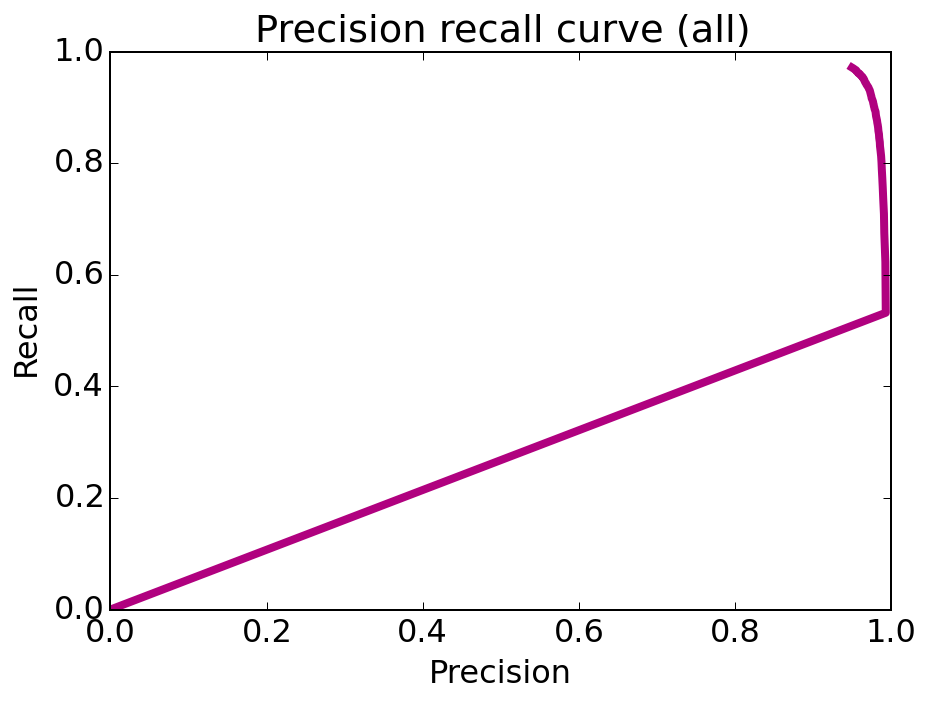

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})
    
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

In [84]:
new_list = []
for i in zip(threshold_values, precision_all):
    thre, preci = i
   
    if preci >= 0.965:
        new_list.append(thre) 
        
print min(new_list)

    

0.707070707071


Quiz Question: Using threshold = 0.98, how many false negatives do we get on the test_data? This is the number of false negatives (i.e the number of reviews to look at when not needed) that we have to deal with using this classifier.



In [87]:
cmat = confusion_matrix(y_true=test_data['sentiment'],
                        y_pred=apply_threshold(probabilities, 0.98),
                        labels=model.classes_)    # use the same order of class as the LR model.
print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  5047
     -1       |        1        |   194
      1       |       -1        |  8208
      1       |        1        | 19887


##Evaluating specific search terms

So far, we looked at the number of false positives for the entire test set. In this section, let's select reviews using a specific search term and optimize the precision on these reviews only. After all, a manufacturer would be interested in tuning the false positive rate just for their products (the reviews they want to read) rather than that of the entire set of products on Amazon.



##Precision-Recall on all baby related items

From the test set, select all the reviews for all products with the word 'baby' in them. If you are using SFrame, generate a binary mask with apply() and index test_data with the mask. Save the selection to a new data frame named baby_reviews.

In [90]:
test_data['name'] = test_data['name'].astype('str')

/Users/April/anaconda/envs/dato-env/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [91]:
baby_reviews = test_data[test_data['name'].apply(lambda x: 'baby' in x.lower())]

Now, let's predict the probability of classifying these reviews as positive. Make sure to convert the column review_clean of baby_reviews into a 2D array before computing class probability values. In scikit-learn, this task would be implemented as follows:

In [92]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = model.predict_proba(baby_matrix)[:,1]

 Let's plot the precision-recall curve for the baby_reviews dataset. We again use 100 equally spaced values between 0.5 and 1 for the threshold.

In [93]:
threshold_values = np.linspace(0.5, 1, num=100)

In [96]:
precision_all = [precision_score(y_true=baby_reviews['sentiment'], y_pred=apply_threshold(probabilities, threshold))
                 for threshold in threshold_values ]

recall_all = [recall_score(y_true=baby_reviews['sentiment'], y_pred=apply_threshold(probabilities, threshold))
                 for threshold in threshold_values]

In [97]:
new_list = []
for i in zip(threshold_values, precision_all):
    thre, preci = i
   
    if preci >= 0.965:
        new_list.append(thre) 
        
print min(new_list)

0.737373737374


###Plot the precision-recall curve for baby_reviews only by running

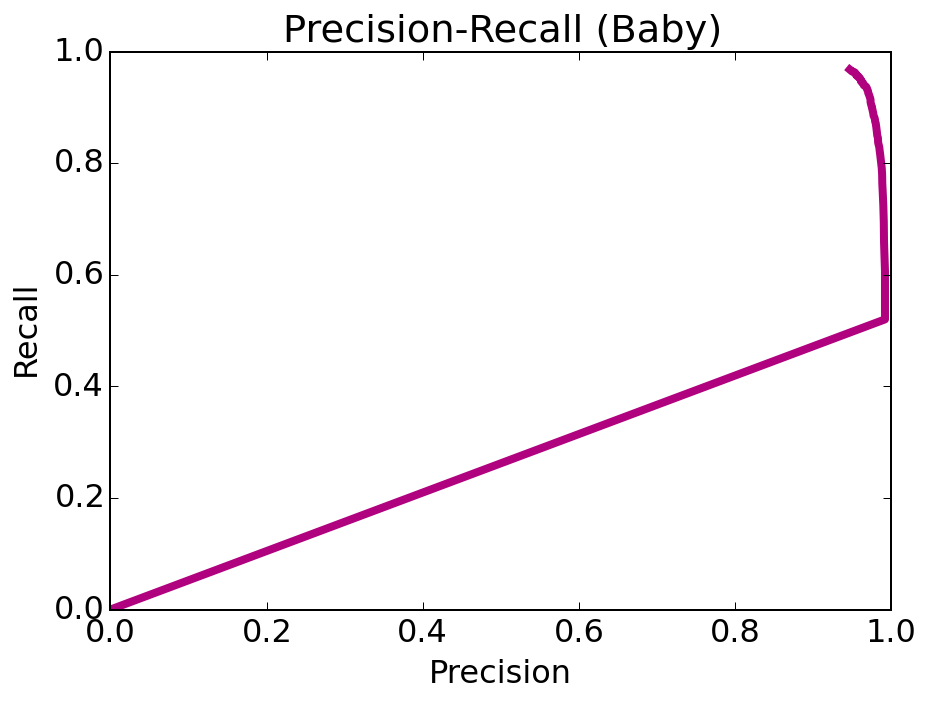

In [98]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")